In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import os
import joblib

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option('display.max_rows',100)

from pylab import mpl 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常


In [2]:
# 加载数据
file_path = "E:\竞赛\服创赛-A08\data\process_data.csv"
data = pd.read_csv(file_path)


# file_path = 'E:\竞赛\服创赛-A08\data\欺诈手段特征集.xlsx'
# data = pd.read_excel(file_path)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 82 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   个人编码               16000 non-null  float64
 1   一天去两家医院的天数         16000 non-null  int64  
 2   就诊的月数              16000 non-null  int64  
 3   月就诊天数_MAX          16000 non-null  int64  
 4   月就诊天数_AVG          16000 non-null  float64
 5   月就诊医院数_MAX         16000 non-null  int64  
 6   月就诊医院数_AVG         16000 non-null  float64
 7   就诊次数_SUM           16000 non-null  int64  
 8   月就诊次数_MAX          16000 non-null  int64  
 9   月就诊次数_AVG          16000 non-null  float64
 10  月统筹金额_MAX          16000 non-null  float64
 11  月统筹金额_AVG          16000 non-null  float64
 12  月药品金额_MAX          16000 non-null  float64
 13  月药品金额_AVG          16000 non-null  float64
 14  医院_就诊天数_MAX        16000 non-null  int64  
 15  医院_就诊天数_AVG        16000 non-null  float64
 16  医院_统筹金_MAX         160

In [3]:
def strategy_3(X, y, model, test_size=0.3, random_state=42, smote_random_state=42, k_neighbors=5):
    """
    使用SMOTE策略训练模型，并返回分类报告。

    参数:
    - X: DataFrame, 特征数据集。
    - y: Series, 目标变量数据集。
    - model: 机器学习模型。
    - test_size: float, 测试集占比。
    - random_state: int, train_test_split的随机状态。
    - smote_random_state: int, SMOTE的随机状态。
    - k_neighbors: int, SMOTE中的最近邻数量。

    返回:
    - 分类报告。
    """
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # 应用SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=smote_random_state, k_neighbors=k_neighbors)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # 训练模型
    model.fit(X_train_smote, y_train_smote)

    # 进行预测
    y_pred = model.predict(X_test)

    # 生成分类报告
    classification_rep = classification_report(y_test, y_pred)

    return classification_rep,model

In [4]:
def strategy_4(model, X_test, y_test, thresholds):

    classification_reports = {}
    for thresh in thresholds:
        # 以概率形式获取预测结果
        y_probs = model.predict_proba(X_test)[:, 1]  # 获取正类的概率
        # 应用阈值
        y_pred_thresh = np.where(y_probs > thresh, 1, 0)
        # 生成并存储分类报告
        classification_reports[thresh] = classification_report(y_test, y_pred_thresh)

    return classification_reports

In [5]:
def load_and_split_data(input_data, target_column='RES', test_size=0.3, random_state=42):
    # Load the dataset if a file path is provided, else use the DataFrame directly
    if isinstance(input_data, str):
        _, file_extension = os.path.splitext(input_data)
        if file_extension.lower() == '.csv':
            data = pd.read_csv(input_data)
        elif file_extension.lower() == '.xlsx':
            data = pd.read_excel(input_data)
        else:
            raise ValueError("Unsupported file format. Only CSV and Excel files are supported.")
    elif isinstance(input_data, pd.DataFrame):
        data = input_data
    else:
        raise ValueError("Input data should be a file path or a DataFrame.")

    # Separate features and target
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Handle class imbalance
    data_majority = data[data[target_column] == 0]
    data_minority = data[data[target_column] == 1]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test, X, y, data_majority, data_minority

In [6]:
# 分离特征和目标变量
X = data.drop('RES', axis=1)
y = data['RES']

# 分离类别
data_majority = data[data.RES == 0]
data_minority = data[data.RES == 1]

In [7]:
model = RandomForestClassifier(
    n_estimators=100,
    #max_depth=5,
    random_state=123,
    n_jobs=-1
)

In [8]:
# # 定义XGBoost模型
# from xgboost import XGBClassifier
# model = XGBClassifier(
#         learning_rate = 0.05,
#         n_estimators=1000,
#         max_depth=7,
#         min_child_weight=5,
#         gamma=0,
#         subsample=0.9,
#         colsample_bytree=0.6,
#         objective='binary:logistic',
#         nthread=4,
#         scale_pos_weight=1,
#         seed=27
#     )

In [9]:
# 应用 strategy_3
classification_reports,model = strategy_3(X, y, model)

# 打印分类报告

print(classification_reports)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4563
           1       0.46      0.43      0.44       237

    accuracy                           0.95      4800
   macro avg       0.72      0.70      0.71      4800
weighted avg       0.95      0.95      0.95      4800



In [10]:
X_train, X_test, y_train, y_test ,X,y,data_majority, data_minority= load_and_split_data(file_path)
# model = model.fit(X_train,y_train)

In [11]:
thresholds = [ 0.5,0.55, 0.6,0.65, 0.7,0.75]
reports = strategy_4(model,X_test, y_test, thresholds)

# 输出每个阈值下的分类报告
for thresh, report in reports.items():
    print(f"Threshold: {thresh}\n", report)

Threshold: 0.5
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4563
           1       0.46      0.43      0.44       237

    accuracy                           0.95      4800
   macro avg       0.72      0.70      0.71      4800
weighted avg       0.95      0.95      0.95      4800

Threshold: 0.55
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      4563
           1       0.53      0.39      0.45       237

    accuracy                           0.95      4800
   macro avg       0.75      0.69      0.71      4800
weighted avg       0.95      0.95      0.95      4800

Threshold: 0.6
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      4563
           1       0.57      0.36      0.44       237

    accuracy                           0.95      4800
   macro avg       0.77      0.67      0.71      4800
weighted avg       0.95  

In [12]:
thresholds = [0.6]
reports = strategy_4(model,X_test, y_test,thresholds)
# report

# 输出每个阈值下的分类报告
for thresh, report in reports.items():
    print(f"Threshold: {thresh}\n", report)

Threshold: 0.6
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      4563
           1       0.57      0.36      0.44       237

    accuracy                           0.95      4800
   macro avg       0.77      0.67      0.71      4800
weighted avg       0.95      0.95      0.95      4800



In [13]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 计算AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.885653823498679


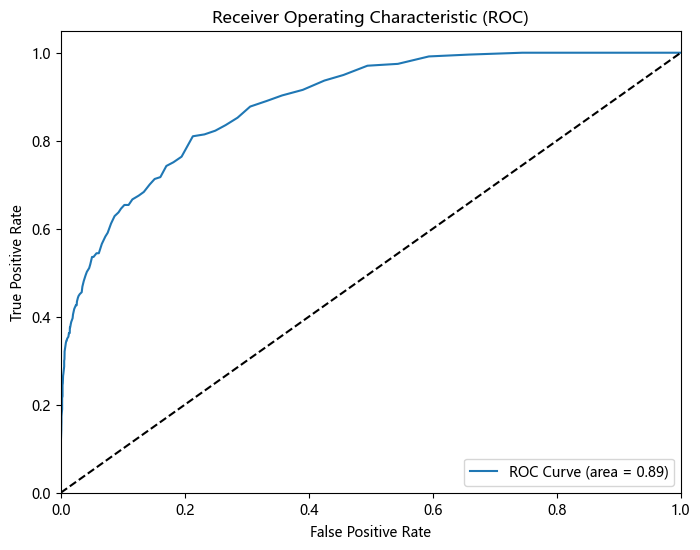

In [14]:
# 获取真正率（TPR）和假正率（FPR）以及阈值用于绘制ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 随机概率的对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [15]:
# 获取特征重要性
feature_importances = model.feature_importances_

# 排序特征重要性
sorted_idx = np.argsort(feature_importances)[::-1]

# 取出前二十个重要特征
top_20_features = np.array(X_train.columns)[sorted_idx][:32]

top_20_features

array(['治疗费发生金额_SUM', '治疗费申报金额_SUM', '月统筹金额_MAX', '贵重药品发生金额_SUM',
       '起付标准以上自负比例金额_SUM', '月药品金额_MAX', '药品费自费金额_SUM', '中草药费发生金额_SUM',
       '治疗费用在总金额占比', '床位费申报金额_SUM', '非账户支付金额_SUM', '月药品金额_AVG',
       '可用账户报销金额_SUM', '个人账户金额_SUM', '基本个人账户支付_SUM', '床位费发生金额_SUM',
       '个人支付的药品占比', '是否挂号', '一天去两家医院的天数', '月就诊次数_AVG', 'ALL_SUM',
       '中成药费发生金额_SUM', '月就诊医院数_AVG', '基本统筹基金支付金额_SUM', '本次审批金额_SUM',
       '统筹支付金额_SUM', '月就诊次数_MAX', '月就诊天数_AVG', '一次性医用材料申报金额_SUM',
       '月就诊天数_MAX', '月统筹金额_AVG', '医用材料发生金额_SUM'], dtype=object)

## 评估在训练集上的模型性能

In [16]:
# 检测模型在训练集上的效果
# result = classification_report(y_train,model.predict(X_train))
y_proby = model.predict_proba(X_train)[:,1]
thresh = 0.6
result = np.where(y_proby>thresh,1,0)
results = classification_report(y_train,result)

print(results)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10644
           1       1.00      0.99      1.00       556

    accuracy                           1.00     11200
   macro avg       1.00      1.00      1.00     11200
weighted avg       1.00      1.00      1.00     11200

